# Benchmark structural regression

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import matplotlib as mpl
import sys
from math import *
from scipy.stats import binned_statistic
import inspect
import matplotlib as mpl


# Import custom functions
from utils_benchmark import * 
#test()


sns.set_style("white")

evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"

## Load infos

In [2]:
#---------------- FAMILIES INFO
# Load datasets informations (Homfam + extHomfam)
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})


#---------------- AF2 INFO
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
af2_grouped = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/03_summary_af2_grouped.csv")


#---------------- RUNNING TIMES
def extract_all_traces(dataset):
    # ---------- EXTRACT SEQUENCES ---------------
    #traces_extracted_sequences_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "seqs_extracted")
    # ---------- AF2 PREDICTIONS -------------------------
    # traces_af2_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "structures/colabfold")
    # ---------- ALIGNMENTS -------------------------
    traces_alignments_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "alignments", extralevel=True)
    # ---------- CONCATENATE AL OF THEM IN ONE ---------------
    traces = pd.concat([traces_alignments_homfam], ignore_index=True)
    return(traces)

traces = extract_all_traces("homfam")
traces.name.str.split(".", expand = True)[1].value_counts()



# Extract from .score files 
dataset = "homfam"
homoplasy_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"alignments/")
homoplasy = pd.DataFrame()
for root, dirs, files in os.walk(homoplasy_dir):
    for homoplasy_name in files:
        homoplasy_file = os.path.join(root,homoplasy_name)
        # Parse file
        if homoplasy_file.endswith("homoplasy"):
            name = os.path.basename(os.path.dirname(homoplasy_file))
            homoplasy_df = pd.read_csv(homoplasy_file,sep = ":", header = None, engine='python')
            homoplasy_df[1] = homoplasy_df[1].str.strip()
            homoplasy_df = homoplasy_df.set_index(0).T
            homoplasy_df["name"] = name.replace(".homoplasy", "")
            homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
            
            

# Extract from .score files 
dataset = "homfam"
easel_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/easel/")
easel = pd.DataFrame()
for easel_name in os.listdir(easel_dir):
    easel_file = os.path.join(easel_dir,easel_name)
    # Parse file
    if easel_file.endswith("INFO"):
        easel_df = pd.read_csv(easel_file,sep = ":", header = None).drop([0,1,9], axis = 0)
        easel_df[1] = easel_df[1].str.strip()
        easel_df = easel_df.set_index(0).T
        easel_df["name"] = easel_name.replace(".easel_INFO", "")
        easel = easel.append(easel_df, ignore_index=True)

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  traces = traces.append(df)
/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/notebook/utils_benchmark.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  homoplasy = homoplasy.append(homoplasy_df, ignore_index=True)
/tmp/ipykernel_11504/1023051365.py:43: FutureWarning: Th

KeyboardInterrupt: 

##### msa evaluation 


In [3]:
# --------------------- HERE PARSE FROM CSV FILES ---------------------------

# Define dataset 
#dataset = "homfam"
#eval_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/CSV/")
#scores_df = get_evaluation_all(eval_dir)


# Define dataset 
dataset = "homfam"
scores_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/score/")

scores = pd.DataFrame()
for score_name in os.listdir(scores_dir):
    score_file = os.path.join(scores_dir,score_name)
    # Parse file
    if score_file.endswith(".scores"):
        score_df = pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1)
        scores = scores.append(score_df, ignore_index=True)

scores.columns = ['name', 'sp', 'tc', 'column']
scores = pd.merge(scores,easel, on = "name", how = "outer")


# -------------------------
#      Regressive
# -------------------------
regressive_scores = scores[scores.name.str.contains("regressive")]
regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)

# -------------------------
#      Progressive
# -------------------------
progressive_scores = scores[scores.name.str.contains("progressive")]
progressive_scores[["family", "method", "align_method", "tree_method"]] = progressive_scores.name.str.split(".", expand = True)

# -------------------------
#      Dyanmic
# -------------------------
dynamic_scores = scores[scores.name.str.contains("dynamic")]
dynamic_scores[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val","master_msa", "slave_msa", "tree_method"]] = dynamic_scores.name.str.split(".", expand = True)


# --------------   summary all -----------------
scores_df = pd.concat([regressive_scores, progressive_scores, dynamic_scores], ignore_index=True, sort=False)
scores_df = pd.merge(scores_df,homoplasy, how = "left", on = "name")

# sep reference and full
scores_df["tag"] = scores_df.family.str.contains("-ref").map({True: 'ref', False: 'full'})
scores_df.family = scores_df.family.str.replace("-ref","")

# add AF2 
scores_df["benchmarking_dataset"] = dataset
scores_df = pd.merge(scores_df,af2_grouped,on = ["family", "benchmarking_dataset"])
scores_df["bucket_size"] = pd.to_numeric(scores_df.bucket_size)

scores_df_full = scores_df[scores_df.tag == "full"]
scores_df_ref = scores_df[scores_df.tag == "ref"]
scores_df_full.method.value_counts()

scores_df_ref.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "scores_df_refs.csv"), index = False)

/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_11504/104264496.py:20: FutureWarning: The frame.append method is deprecated and will be remov

KeyboardInterrupt: 

## merge: traces, af2, family summary

In [ ]:
def get_stats(scores_df, traces, summary_homfam_exthomfam):
    stats = pd.merge(scores_df, traces, on = ["name","benchmarking_dataset"])
    stats = pd.merge(stats, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
    stats_alignments = stats[stats.task == "alignments"]
    stats_alignments["approach"] = stats_alignments[["method", "bucket_size", "master_msa", "slave_msa", "dynamicX_val"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    stats_alignments["approach"] = stats_alignments.approach.apply(lambda val: val.replace("_nan",""))
    stats_alignments["fam_approach"] = stats_alignments["family"]+"_"+stats_alignments["approach"]
    stats_alignments.tc = pd.to_numeric(stats_alignments.tc)
    return(stats_alignments)

In [ ]:
stats_alignments_full = get_stats(scores_df_full, traces, summary_homfam_exthomfam)
stats_alignments_ref = get_stats(scores_df_ref, traces, summary_homfam_exthomfam)

# Only keep the ones with ref 
stats_alignments_full_sorted = stats_alignments_full.loc[stats_alignments_full.fam_approach.isin(stats_alignments_ref.fam_approach)]
stats_alignments_full_sorted = stats_alignments_full_sorted.sort_values(by=["family", "approach"]).reset_index()
stats_alignments_ref_sorted = stats_alignments_ref.sort_values(by=["family", "approach"]).reset_index()

# ----------------------------------------------
#     Calculate the difference in TCs 
# -----------------------------------------------
stats_alignments_full_sorted = pd.merge(stats_alignments_full_sorted, stats_alignments_ref_sorted, on = ["family", "approach", "method", "bucket_size", "align_method", "tree_method", "file", "dynamicX_val", "master_msa"] )
stats_alignments_full_sorted["diff_tc"] = stats_alignments_full_sorted.tc_x - stats_alignments_full_sorted.tc_y 
stats_alignments_full_sorted["diff_sp"] = stats_alignments_full_sorted.sp_x - stats_alignments_full_sorted.sp_y 

stats_alignments_full_sorted.columns = stats_alignments_full_sorted.columns.str.replace("_x", "").str.replace("_y", "_ref")
# ----------   Get diff TC --------- 
#stats_alignments_full_sorted["diff_tc"] = stats_alignments_full_sorted.tc - stats_alignments_ref_sorted.tc
stats_alignments_full_sorted["diff_tc_perc"] = (stats_alignments_full_sorted.diff_tc / stats_alignments_ref_sorted.tc)*100



fams= traces.name.str.split(".",expand=True)[0].unique()
stats = pd.merge(scores_df, traces, on = ["name","benchmarking_dataset"])
stats = pd.merge(stats, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])

stats_alignments_full = get_stats(scores_df_full, traces, summary_homfam_exthomfam)
stats_alignments_full = stats_alignments_full_sorted
stats_alignments_dynamic = stats_alignments_full[(stats_alignments_full.method == "dynamic")]
fams = stats_alignments_dynamic.family
stats_alignments_progressive = stats_alignments_full[(stats_alignments_full.method == "progressive") ]
stats_alignments_regressive = stats_alignments_full[(stats_alignments_full.method == "regressive") ]
#save 
#stats_alignments_full.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "stats_alignments_full.csv"), index = False)
#stats_alignments_ref.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "stats_alignments_refs.csv"), index = False)

In [ ]:
stats_alignments_ref

# Plotting params 

In [ ]:
metrics = [["sp", "sum of pairs"], ["tc", "total column"], ["column", "column"]]
metrics = [["tc", "total column"]]
sns.set_context("talk")

In [ ]:
prog = stats_alignments_progressive

reg_50 = stats_alignments_regressive[stats_alignments_regressive.bucket_size == 50]
reg_1000 = stats_alignments_regressive[stats_alignments_regressive.bucket_size == 1000]

dyn_1_famsa = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "1") & (stats_alignments_dynamic.master_msa == "famsa_msa")]
dyn_1_3d = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "1") & (stats_alignments_dynamic.master_msa == "tcoffee_msa")]

dyn_1000_famsa = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "1000") & (stats_alignments_dynamic.master_msa == "famsa_msa")]
dyn_1000_3d = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "1000") & (stats_alignments_dynamic.master_msa == "tcoffee_msa")]

dyn_100000000_famsa = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "100000000") & (stats_alignments_dynamic.master_msa == "famsa_msa")]
dyn_100000000_3d = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "100000000") & (stats_alignments_dynamic.master_msa == "tcoffee_msa")]

In [ ]:
dyn_100000000_3d

In [ ]:
plot_scatter_perc(prog,dyn_100000000_3d,'progressive with FAMSA', 'Dynamic 3D', metric = "sp")

# Dynamic

## DyanmicX

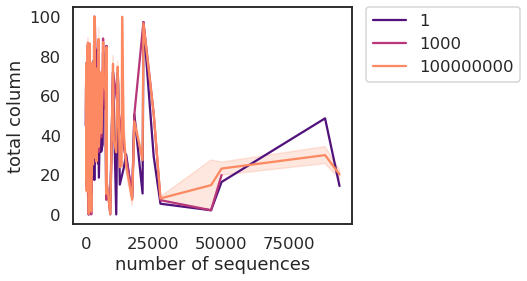

In [8]:
for metric in metrics:
    f, ax = plt.subplots(figsize=(5, 4))
    sns.lineplot(data=stats_alignments_dynamic, y=metric[0], x="n_sequences", hue="dynamicX_val",
                    palette = "magma")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=  metric[1], xlabel='number of sequences')

# -------------------------------
#plot_scatter_perc(dyn_1_3d,dyn_1000_3d,'dyn_1_3d', 'dyn_1000_3d', title  = "dynamic on homfam")
#plot_scatter_perc(dyn_1000_3d,dyn_100000000_3d,'dyn_1000_3d', 'dyn_100000000_3d', title  = "dynamic on homfam")
#plot_scatter_perc(dyn_1000_famsa,dyn_1000_3d,'dyn_1000_famsa', 'dyn_1000_3d')

## parent aligner

 barplot with 
 - how many better w/famsa 
 - how many better w/3d 
df

<AxesSubplot:xlabel='better', ylabel='Count'>

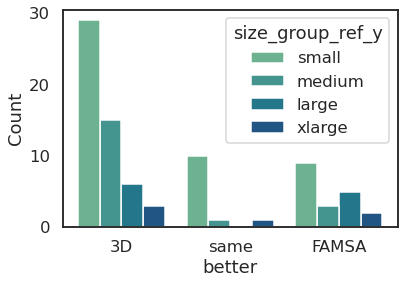

In [65]:
df1 = dyn_100000000_famsa
df2 = dyn_100000000_3d

df = df1.merge(df2, on = ["family","n_sequences"])

sns.set_palette("tab10")

df["better"] = "same"
df.loc[df.tc_x > df.tc_y, 'better'] = "FAMSA"
df.loc[df.tc_x < df.tc_y, 'better'] = "3D"

sns.histplot(data=df, x="better", hue = "size_group_ref_y",palette = "crest",
             alpha = 1, multiple="dodge",
             hue_order=["small", "medium", "large", "xlarge"], shrink =.8)



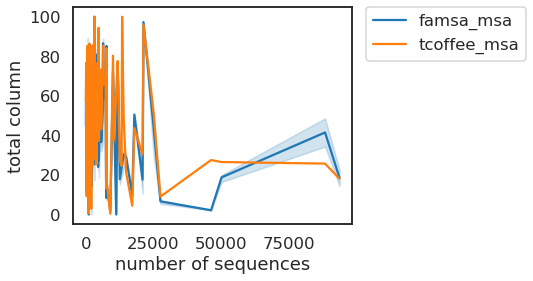

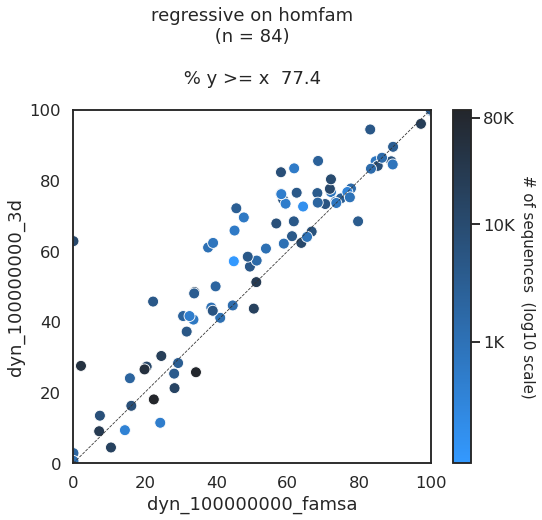

In [81]:
for metric in metrics:
    f, ax = plt.subplots(figsize=(5, 4))
    sns.lineplot(data=stats_alignments_dynamic, y=metric[0], x="n_sequences", hue="master_msa")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=  metric[1], xlabel='number of sequences')
    
plot_scatter_perc(dyn_100000000_famsa,dyn_100000000_3d,'dyn_100000000_famsa', 'dyn_100000000_3d')
#plot_scatter_perc(dyn_1000_famsa,dyn_10000000_3d,'dyn_1000_famsa', 'dyn_1000_3d')

# Regressive

### Which is the bucket size effect? 

In [82]:
stats_alignments_regressive_all = stats_alignments_full[(stats_alignments_full.method == "regressive")]
reg_50_all = stats_alignments_regressive_all[stats_alignments_regressive_all.bucket_size == 50]
reg_1000_all = stats_alignments_regressive_all[stats_alignments_regressive_all.bucket_size == 1000]

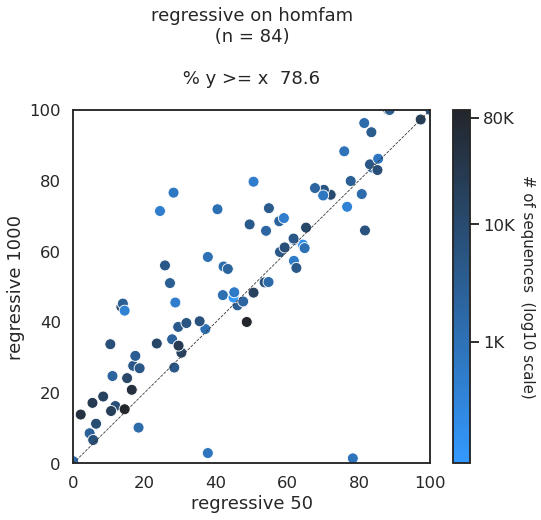

In [83]:
plot_scatter_perc(reg_50_all,reg_1000_all,'regressive 50', 'regressive 1000')

# Compare dynamic vs regressive

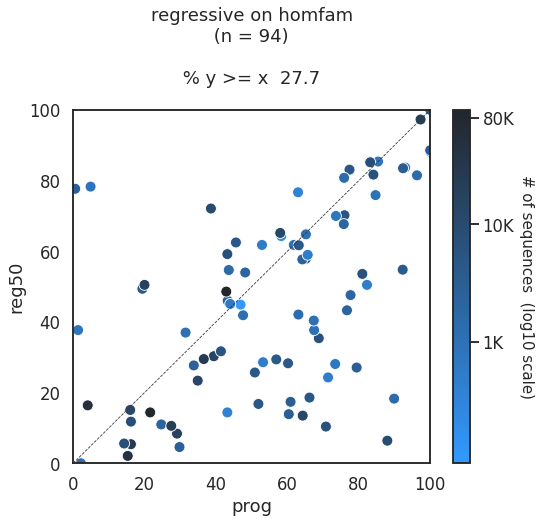

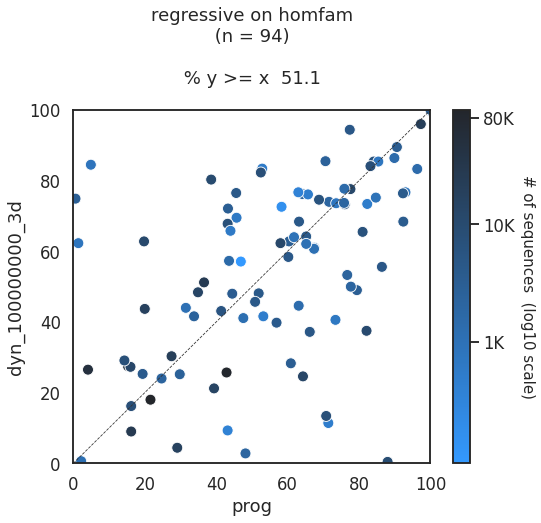

In [158]:
plot_scatter_perc(prog,reg_50,'prog', 'reg50')
#plot_scatter_perc(prog,reg_1000,'prog', 'reg1000')
#plot_scatter_perc(prog,dyn_1_famsa,'prog', 'dyn_1_famsa')
#plot_scatter_perc(prog,dyn_1_3d,'prog', 'dyn_1_3d')
#plot_scatter_perc(prog,dyn_100000000_famsa,'prog', 'dyn_100000000_famsa')
plot_scatter_perc(prog,dyn_100000000_3d,'prog', 'dyn_100000000_3d')

In [87]:
# Here was to pick out some examples for testing saturation 
df1 = prog
df2 = dyn_100000000_3d
df = df1.merge(df2, on = ["family","n_sequences"])
df[(df.family.isin(list(["cyt3","egf","cryst"])))][["name_x", "sp_x", "tc_x", "sp_y", "tc_y", "n_sequences"]]

,name_x,sp_x,tc_x,sp_y,tc_y,n_sequences
29,cryst.progressive.FAMSA.FAMSA-medoid,48.2,2.2,47.8,0.6,1160
32,cyt3.progressive.FAMSA.FAMSA-medoid,71.6,43.2,58.2,9.3,385
34,egf.progressive.FAMSA.FAMSA-medoid,66.3,16.2,63.8,16.2,7774


# Cumulative average plot

In [159]:
#df = stats_alignments_full[stats_alignments_full.n_sequences > 1000]
df = stats_alignments_full
df_dyn = df[df.approach == "dynamic_50.0_tcoffee_msa_famsa_msa_100000000"]
fams = (df_dyn.family.unique())

df_prog = df[(df.approach == "progressive") & (df.family.isin(fams))]
df_reg = df[(df.approach == "regressive_50.0")  & (df.family.isin(fams))]
df = pd.concat([df_dyn, df_reg, df_prog])
df.family.unique().shape

df_d_r = pd.merge(df_dyn, df_prog, on = ["family"] )
df_d_r["diff_tc"] = df_d_r.tc_x - df_d_r.tc_y
df_d_r["perc_change_tc"]= df_d_r.diff_tc *100/ abs(df_d_r.tc_y) 
df_d_r["diff_sp"] = df_d_r.sp_x - df_d_r.sp_y / abs(df_d_r.sp_y * 100)


df_d_r["Alignment length_x"] = pd.to_numeric(df_d_r["Alignment length_x"])
df_d_r["Average identity_x"] = pd.to_numeric(df_d_r["Average identity_x"].str.replace("%", ""))
df_d_r["Smallest_x"] = pd.to_numeric(df_d_r["Smallest_x"])
df_d_r["Largest_x"] = pd.to_numeric(df_d_r["Largest_x"])
df_d_r["NGAP_x"] = pd.to_numeric(df_d_r["NGAP_x"])


# Which are the ones for which we do not get better? 
family_worst = list(df_d_r[df_d_r.diff_tc < 0].family)
df_d_r["diff_qualitatively"] = "better"
df_d_r.loc[df_d_r.diff_tc < 0, 'diff_qualitatively'] = "worst"
df_d_r.diff_qualitatively.value_counts()

better    48
worst     46
Name: diff_qualitatively, dtype: int64

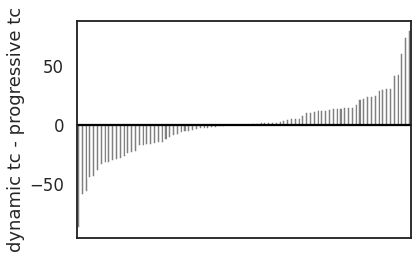

In [160]:
# Center the data to make it diverging
ax = sns.barplot(x=df_d_r.diff_tc, y=df_d_r.diff_tc, color = "grey")
ax.set(xlabel="", ylabel = "dynamic tc - progressive tc", xticklabels="")
ax.axhline(0, color="k", clip_on=False)

<AxesSubplot:xlabel='diff_qualitatively', ylabel='n_sequences_x'>

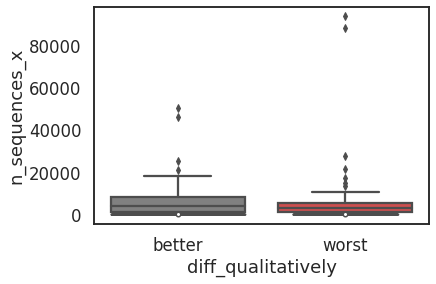

In [161]:
sns.violinplot(data = df_d_r, y = "plddt_mean_x", x = "diff_qualitatively")
sns.boxplot(data = df_d_r, y = "n_sequences_x", x = "diff_qualitatively")

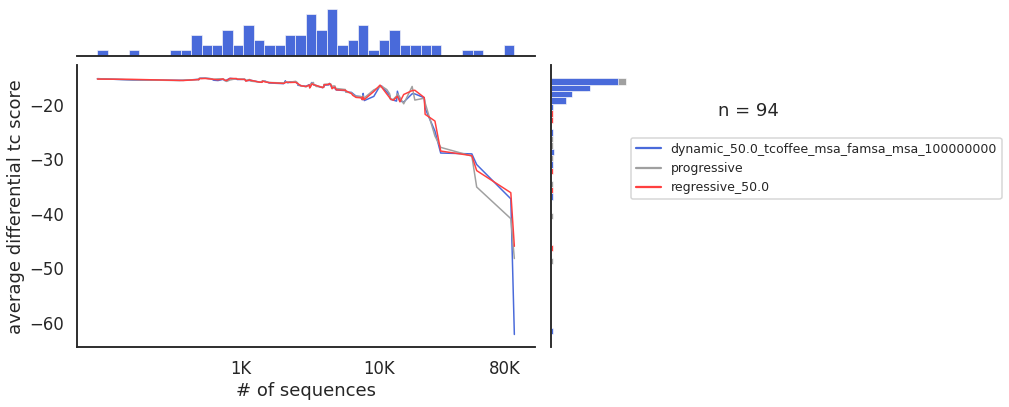

In [162]:
# -------------------------------
#           Plot TC 
# ------------------------------
#df = df[df.n_sequences > 1000]
df["n_sequences_log"] = np.log10( df["n_sequences"] )


x = df.n_sequences_log
y = cumavg(df.sort_values(by=["n_sequences_log"], ascending = False)["diff_tc"])
hue = df["approach"]

colors = [ "#496ADA","#A0A0A0", "#FF3F3F" ]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

ax = sns.JointGrid(x = x, y = y, hue = hue)
ax.plot_joint(sns.lineplot,  linewidth=1.5)
ax.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=40)
ax.ax_joint.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=5.8, fontsize = "x-small")
ax.fig.set_figwidth(10)
ax.fig.set_figheight(6)

ax.ax_joint.set(xlabel = "# of sequences", ylabel = "average differential tc score")
ax.ax_joint.set_xticks(np.log10([1000,10000,80000]))
ax.ax_joint.set_xticklabels(["1K", "10K", "80K"]) 
plt.title("n = "+str(len(fams)), x=2.5, y=0.8)


outdir = "../../../data/structural_regression/plots/03_benchmarkDynamic/" 
plt.savefig(os.path.join(outdir, "01_seq_vs_tc.pdf"))


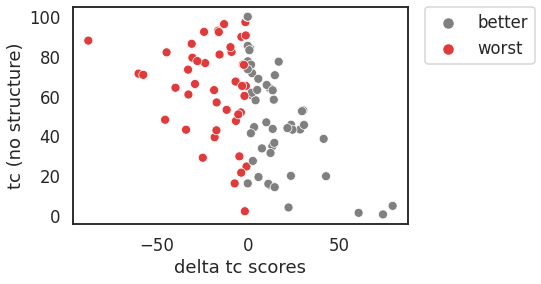

In [163]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, x = "diff_tc", y = "tc_y", hue = "diff_qualitatively").set(ylabel = "tc (no structure)", xlabel = "delta tc scores")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


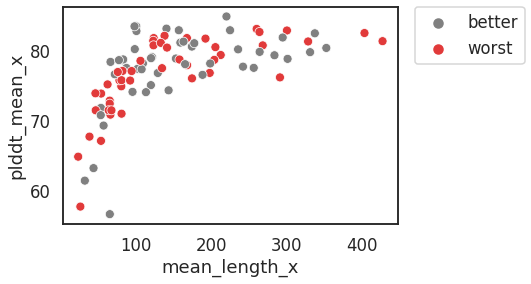

In [164]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, x = "mean_length_x", y = "plddt_mean_x", hue = "diff_qualitatively")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

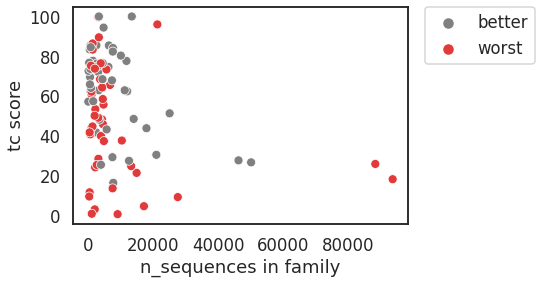

In [165]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, y = "tc_x", x = "n_sequences_x", hue = "diff_qualitatively").set(xlabel  ="n_sequences in family", ylabel = "tc score")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

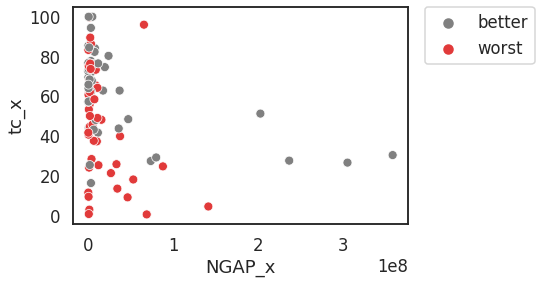

In [166]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, y = "tc_x", x = "NGAP_x", hue = "diff_qualitatively")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

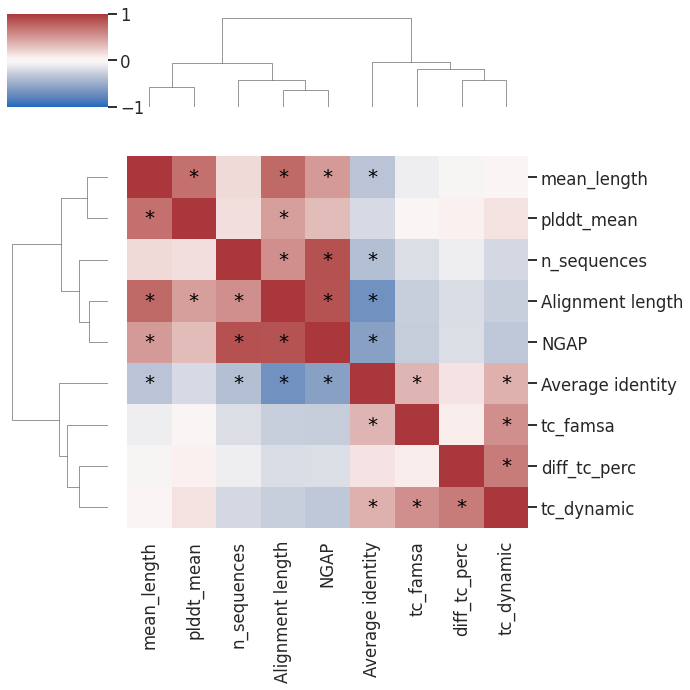

In [167]:



df_correlation = df_d_r[["diff_tc_perc_x","tc_x","tc_y",
                         "n_sequences_x",
                         "mean_length_x", "plddt_mean_x",
                         "Alignment length_x", "Average identity_x", 
                         "NGAP_x"]]
#df_d_r = df_d_r[df_d_r.n_sequences_x > 1000]
df_correlation.columns = df_correlation.columns.str.replace("tc_x","tc_dynamic")
df_correlation.columns = df_correlation.columns.str.replace("tc_y","tc_famsa")

df_correlation.columns = df_correlation.columns.str.replace("_x","")
df_correlation.columns = df_correlation.columns.str.replace("_y","_ref")


from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
def get_correlations(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    correlations = dfcols.transpose().join(dfcols, how="outer")
    for ix, r in enumerate(df.columns):
        for jx, c in enumerate(df.columns):
            sp = spearmanr(df[r], df[c])
            correlations[c][r] = sp[0]
            pvalues[c][r] = sp[1] if ix > jx else np.nan  # Only store values below the diagonal
    return correlations.astype("float"), pvalues.astype("float")


correlations, uncorrected_p_values = get_correlations(df_correlation)

# Correct p-values for multiple testing and check significance (True if the corrected p-value < 0.05)
shape = uncorrected_p_values.values.shape
significant_matrix = multipletests(uncorrected_p_values.values.flatten())[0].reshape(
    shape
)

# Here we start plotting
g = sns.clustermap(correlations, cmap="vlag", vmin=-1, vmax=1)

# Here labels on the y-axis are rotated
for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

# Here we add asterisks onto cells with signficant correlations
for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if significant_matrix[ix, jx] or significant_matrix[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

# Save a high-res copy of the image to disk
plt.tight_layout()
plt.savefig("clustermap.png", dpi=200)

# Extra plots

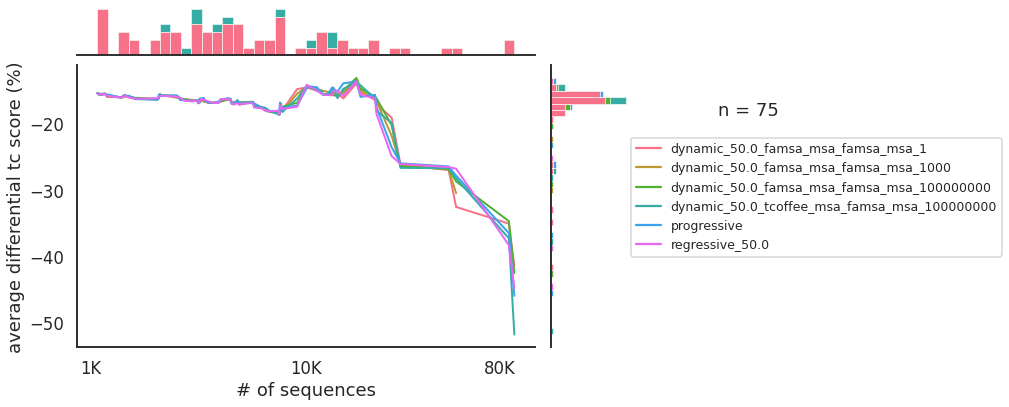

In [60]:
# --------------------------------
#         Plot TC difference
# --------------------------------
stats_alignments_regressive_50  = stats_alignments_regressive[stats_alignments_regressive.bucket_size == 50]
df = pd.concat([stats_alignments_regressive_50,stats_alignments_progressive, stats_alignments_dynamic])
#df = stats_alignments_full
df = df[df.n_sequences > 1000]
df["n_sequences"] = np.log10( df["n_sequences"] )  
fams = (df.family.unique())


x = df.n_sequences
y = cumavg(df.sort_values(by=["n_sequences"], ascending = False)["diff_tc"])
hue = df["approach"]

colors = [ "#496ADA","#A0A0A0", "#FF3F3F" ]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))



ax = sns.JointGrid(x = x, y = y, hue = hue)
ax.plot_joint(sns.lineplot,  linewidth=2)
ax.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=40)
ax.ax_joint.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=5.8, fontsize = "x-small")
ax.fig.set_figwidth(10)
ax.fig.set_figheight(6)

ax.ax_joint.set(xlabel = "# of sequences", ylabel = "average differential tc score (%)")
ax.ax_joint.set_xticks(np.log10([1000,10000,80000]))

ax.ax_joint.set_xticklabels(["1K", "10K", "80K"]) 
plt.title("n = "+str(len(fams)), x=2.5, y=0.8)


outdir = "../../../data/structural_regression/plots/03_benchmarkDynamic/" 
plt.savefig(os.path.join(outdir, "01_seq_vs_tc.pdf"))

# add more sequences: 100 

In [168]:
stats_alignments_full[stats_alignments_full.bucket_size == 100]

,index,name,sp,tc,column,Number of sequences,Alignment length,Total # residues,Smallest,Largest,...,n_sequences_ref,mean_length_ref,min_length_ref,max_length_ref,size_group_ref,perc_ref_total_ref,fam_approach_ref,diff_tc,diff_sp,diff_tc_perc


In [169]:
stats_alignments_full = get_stats(scores_df_full, traces, summary_homfam_exthomfam)


In [179]:
fam_100 = scores_df_full[(scores_df_full.method == "dynamic") & (scores_df_full.bucket_size == 100)].family.unique()

df = scores_df_full
df_dyn = df[(df.method == "dynamic") & (df.dynamicX_val == "100000000") & (df.master_msa == "tcoffee_msa")]
fams = fam_100
df_dyn = df_dyn[df_dyn.family.isin(fams)]

df_prog = df[(df.method == "progressive") & (df.family.isin(fams))]
df_reg = df[(df.method == "regressive")  & (df.bucket_size == 50) & (df.family.isin(fams))]
df = pd.concat([df_dyn, df_reg, df_prog])

df["method_expanded"] = df[["method", "bucket_size"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
df.method_expanded = df.method_expanded.str.replace("_nan", "")

In [181]:
df

,name,sp,tc,column,Number of sequences,Alignment length,Total # residues,Smallest,Largest,Average length,...,WEIGHTED_HOMOPLASY2,LEN,NGAP,NGAP2,tag,benchmarking_dataset,plddt_mean,plddt_min,plddt_max,method_expanded
633,sdr.dynamic.100.dynamicX.100000000.tcoffee_msa...,67.8,25.6,33.7,50157,6923,8188258,21,297,163.3,...,37314,6921,339048653,2982616131l,full,homfam,81.290758,58.0199,88.0147,dynamic_100.0
642,sdr.dynamic.50.dynamicX.100000000.tcoffee_msa....,69.7,26.5,35.0,50157,6250,8188258,21,297,163.3,...,43305,6248,305292992,3714223758l,full,homfam,81.290758,58.0199,88.0147,dynamic_50.0
794,Acetyltransf.dynamic.100.dynamicX.100000000.tc...,72.7,31.2,36.5,46285,6268,3841179,28,181,83.0,...,76579,6266,286273201,1615310411l,full,homfam,78.603788,60.7213,86.1721,dynamic_100.0
798,Acetyltransf.dynamic.50.dynamicX.100000000.tco...,70.8,27.5,31.1,46285,5196,3841179,28,181,83.0,...,67320,5194,236655681,1054305959l,full,homfam,78.603788,60.7213,86.1721,dynamic_50.0
1016,rvp.dynamic.50.dynamicX.100000000.tcoffee_msa....,44.3,18.0,20.3,93681,660,8833046,22,133,94.3,...,565,658,52996414,1460249206l,full,homfam,77.074836,34.1170,84.4000,dynamic_50.0
1019,rvp.dynamic.100.dynamicX.100000000.tcoffee_msa...,39.7,18.0,20.3,93681,637,8833046,22,133,94.3,...,772,635,50841751,897957089l,full,homfam,77.074836,34.1170,84.4000,dynamic_100.0
630,sdr.regressive.50.FAMSA.FAMSA-medoid,57.8,16.4,22.4,50157,29464,8188258,21,297,163.3,...,76658,29462,1469637590,3634505752l,full,homfam,81.290758,58.0199,88.0147,regressive_50.0
788,Acetyltransf.regressive.50.FAMSA.FAMSA-medoid,36.8,2.1,2.4,46285,25710,3841179,28,181,83.0,...,79759,25708,1186146171,1794293535l,full,homfam,78.603788,60.7213,86.1721,regressive_50.0
1006,rvp.regressive.50.FAMSA.FAMSA-medoid,33.6,14.4,16.2,93681,1590,8833046,22,133,94.3,...,1716,1588,140119744,1350610526l,full,homfam,77.074836,34.1170,84.4000,regressive_50.0
632,sdr.progressive.FAMSA.FAMSA-medoid,50.4,4.1,4.3,50157,6238,8188258,21,297,163.3,...,NaN,NaN,NaN,NaN,full,homfam,81.290758,58.0199,88.0147,progressive


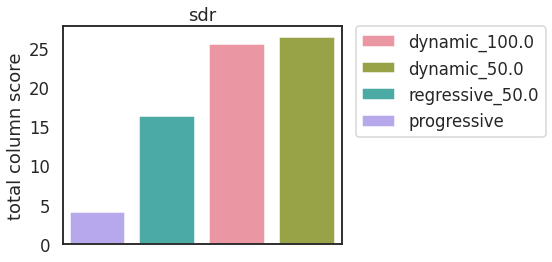

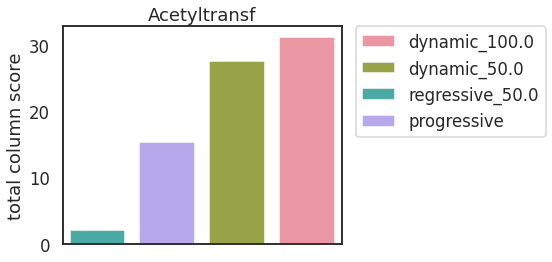

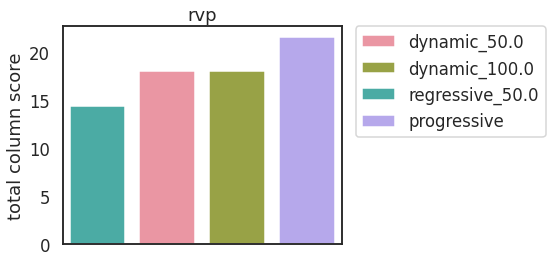

In [182]:
for family in fam_100: 
    df_plot = df[df.family == family]
    f, ax = plt.subplots(figsize=(5, 4))
    ax=sns.barplot(x="name", y="tc", data=df_plot, hue="method_expanded", order=df_plot.sort_values('tc').name, dodge = False)
    ax.set(xticklabels="", xlabel = "", ylabel = "total column score", title = family)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [185]:
stats_alignments_full[stats_alignments_full.family == "rvp"].n_sequences

502    93681
503    93681
504    93681
505    93681
506    93681
507    93681
508    93681
509    93681
Name: n_sequences, dtype: int64